In [9]:
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
import copy
import scipy
import os
from os.path import exists
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from scipy.optimize import least_squares
import math
from torch import nn, autograd
import torch
import torchvision
import torch.cuda
import torch.optim
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from scipy.fft import fft, ifft
from torch import nn, autograd

from PIL import Image
import cv2

from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_erosion

from utils.file_io import read_hdf5

from utils.file_io import load_scene_fmcw_data
from utils.file_io import load_scene_phase
from utils.file_io import data_init
from utils.file_io import scene_to_2d
from utils.file_io import depth_loader

from utils.utils1 import read_text_lines
from utils.utils1 import plot_normal
from utils.utils1 import phase2depth
from utils.utils1 import spatial_gradient
from utils.utils1 import spatial_gradient_tensor
from utils.utils1 import GradientLoss
from utils.utils1 import WrapEdgeLoss
from utils.utils1 import bg_finetune
from utils.utils1 import GradientLossFinetune
from utils.utils1 import load_bg_depth

from torch.utils.data import Dataset
from dataloader.dataloader1 import DepthDataset
from dataloader import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = 'cuda'
speed_of_light = 299792458
lamda = speed_of_light/71500000

In [10]:
# define root folder path
root_path = "/projects/FHEIDE/GHz_ToF/optica_final_data/"

Network and function Initialization

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.group1 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.Softsign(),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            nn.Dropout(p=0.6),
            nn.Linear(1024, 1024),
            nn.Softsign(),
            
            nn.Linear(1024, 1)
        )
    def forward(self, x):
        return 50 + self.group1(x)


def load_fdn():
    PATH = "/projects/FHEIDE/GHz_ToF/optica_final_data/network/freq_decoding_net.pt"
    network = torch.load(PATH)
    return network

In [12]:
def test_time_optimization(predicted_depth, scene_phase, bg_mask, smooth):
    scene_phase_torch = torch.from_numpy(scene_phase)
    med_filter_depth_torch = torch.from_numpy(predicted_depth)
    bg_mask_torch = torch.from_numpy(bg_mask)
    net_depth_torch = torch.from_numpy(predicted_depth).float()
    opt_out = net_depth_torch.clone()
    
    ############ main optimization ############
    gradient_loss = GradientLoss(scene_phase_torch, med_filter_depth_torch, bg_mask_torch, smooth, weights = [1,1])

    run = [0]
    optimizer = optim.Adam([opt_out.requires_grad_()], lr=1)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, verbose=True)
    
    while run[0] <= 200:
        optimizer.zero_grad()
        loss = gradient_loss(opt_out)

        loss.backward()
        optimizer.step()

        run[0] += 1
    
    opt_depth = opt_out.detach().numpy()
    
    ############ fine tune part 1: wrap edge correction ############
    net_depth_torch2 = torch.from_numpy(opt_depth).float()
    opt_out2 = net_depth_torch2.clone()

    wrapedge_loss = WrapEdgeLoss(scene_phase_torch, bg_mask_torch, smooth, weights = [1,1])

    optimizer = optim.Adam([opt_out2.requires_grad_()], lr = 1.5)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, verbose=True)
    run = [0]

    dh, dv = spatial_gradient(phase2depth(scene_phase, 7.15e9))
    false_mask = np.zeros_like(dh)
    opt_masked_grad = np.where(dv != 0, dv, false_mask)
    opt_masked_grad = np.where(dh != 0, dh, opt_masked_grad)
    opt_masked_grad = np.where(np.logical_and(opt_masked_grad<20 ,opt_masked_grad>-30), opt_masked_grad, false_mask) 


    while run[0] <= 500:
        optimizer.zero_grad()

        loss = wrapedge_loss(opt_out2)
        loss.backward()
        optimizer.step()

        run[0] += 1

    opt_depth2 = opt_out2.detach().numpy()
    phasedepth = phase2depth(scene_phase, 7.15e9)
    net_depth2 = opt_depth2 + phasedepth
    
    ############ fine tune part 2 ############
    net_depth_torch3 = torch.from_numpy(net_depth2).float()
    opt_out3 = net_depth_torch3.clone()

    gradient_loss = GradientLoss(scene_phase_torch, med_filter_depth_torch, bg_mask_torch, smooth, weights = [1,1])

    run = [0]

    optimizer = optim.Adam([opt_out3.requires_grad_()], lr=1.5)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, verbose=True)

    while run[0] <= 1000:
        optimizer.zero_grad()

        loss = gradient_loss(opt_out3)
        loss.backward()
        optimizer.step()

        run[0] += 1

    opt_depth3 = opt_out3.detach().numpy()
    
    ############ fine tune part 3 ############
    net_depth_torch4 = torch.from_numpy(opt_depth3).float()
    opt_out4 = net_depth_torch4.clone()

    gradient_loss_finetune = GradientLossFinetune(scene_phase_torch, torch.from_numpy(opt_depth3), bg_mask_torch, weights = [1,1])

    run = [0]

    optimizer = optim.Adam([opt_out4.requires_grad_()], lr=1.5)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, verbose=True)


    g_score = gradient_loss_finetune(opt_out4)
    print('Gradient Loss : {:4f} '.format(g_score.item()))

    while run[0] <= 1000:#80: #5000:
        optimizer.zero_grad()

        loss = gradient_loss_finetune(opt_out4)
        loss.backward()
        optimizer.step()

        run[0] += 1

    opt_depth4 = opt_out4.detach().numpy()
    final_depth = bg_finetune(root_path, opt_depth4, bg_mask)
    dho, dvo = spatial_gradient(final_depth)
    opt_sn = (plot_normal(dvo, dho)+1)/2

    plt.figure(figsize=(30,7))
    plt.subplot(1,2,1)
    plt.imshow(final_depth, cmap="Spectral")
    plt.title('Reconstructed depth')
    plt.axis('off')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(opt_sn)
    plt.colorbar()
    plt.axis('off')
    plt.title('Normal')
    return final_depth

LOAD SCENE DATA 

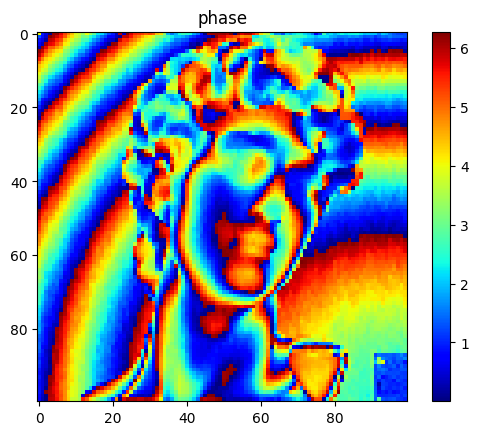

In [13]:
# load scene phase
# model names: "mushroom" "owl" "curlyhair1" "head" "plants"
model_name = "curlyhair1"
scene_phase = load_scene_phase(root_path, model_name)
plt.imshow(scene_phase, cmap="jet")
plt.title('phase')
plt.colorbar()
plt.show()

In [14]:
# load scene signals
scene_data = load_scene_fmcw_data(root_path, model_name)

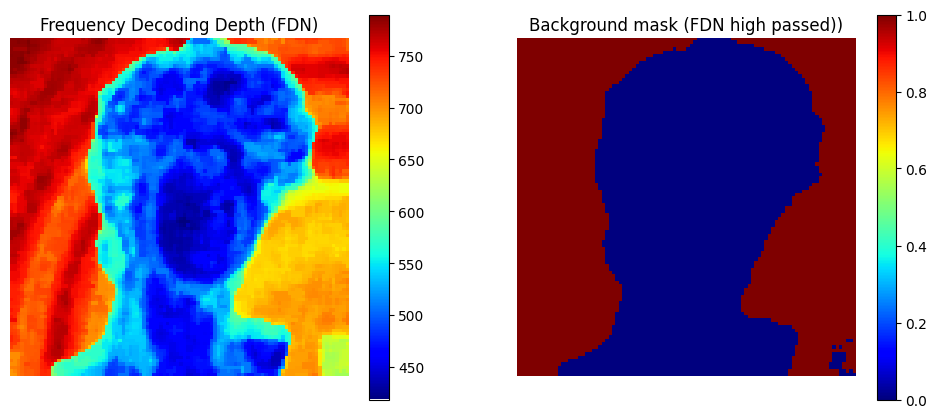

In [18]:
# get depth estimates with depth decoding network 
scene_signals, n_features = data_init(scene_data)

network = load_fdn()
scene_depth = network(scene_signals)
scene_depth = scene_depth.reshape(-1).cpu().detach().numpy()

# getting rid of outliers
scene_depth = np.where(scene_depth > 80, 70, scene_depth)
fdn_depth_2d = scene_to_2d(scene_depth, v = 100, h = 100)
fdn_depth_2d = fdn_depth_2d*10 # cm to m

# seperate object from wall
med_filter_depth = ndi.median_filter(fdn_depth_2d, size=4)
bg_mask = np.where(med_filter_depth < 630, 0, 1)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(med_filter_depth, cmap = 'jet')
plt.axis('off')
plt.colorbar()
plt.title('Frequency Decoding Depth (FDN)')
plt.subplot(1,2,2)
plt.imshow(bg_mask, cmap = 'jet')
plt.axis('off')
plt.title('Background mask (FDN high passed))')
plt.colorbar()

Test Time Optimization

Adjusting learning rate of group 0 to 1.0000e+00.
Adjusting learning rate of group 0 to 1.5000e+00.
Adjusting learning rate of group 0 to 1.5000e+00.
Adjusting learning rate of group 0 to 1.5000e+00.
Gradient Loss : 3.064340 


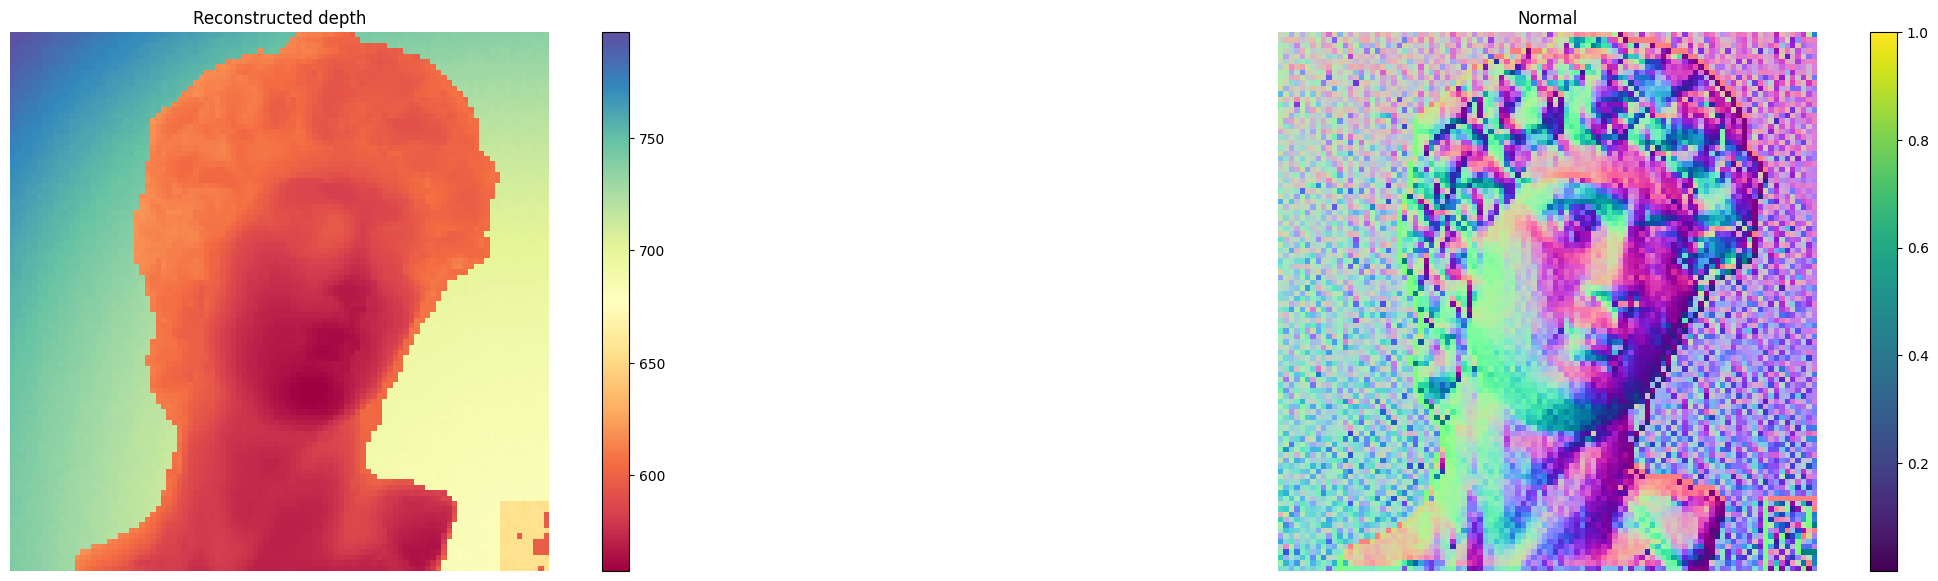

In [16]:
final_depth = test_time_optimization(med_filter_depth, scene_phase, bg_mask, True)